# Feature Organizing
<font size=3><strong>Author:</strong> <a href="https://www.linkedin.com/in/~ashkan/" target="_blank">Ashkan Soltanieh</a><br>
<strong>Date:</strong> Jan. 27, 2022</font>

## Table of Contents

<div class="alert alert-success mt-15">
    <ul>
        <li class="list-unstyled"><a href="#Approach">Approach</a></li>
        <li class="list-unstyled"><a href="#Clustering the Geographic Coordinate Data using DBSCAN">Clustering the Geographic Coordinate Data using DBSCAN</a></li>
        <li class="list-unstyled"><a href="#Plotting Clustered Fire Coordinates">Plotting Clustered Fire Coordinates</a></li>
        <li class="list-unstyled"><a href="#Feature Organizing">Feature Organizing</a></li>
    </ul>
</div>

## Approach
Based on the cleaned and finalized gold data we've gathered so far we have over 30 variables. In this notebook we will be normalizing them using sk-learn StandardScaler. But first, we need to group the latitude and longitude data and bring them into the groups using DBSCAN Clustering. We're expectiong to have arbiterary shaped clusters with potential outliers and for this reason using Density-Based clustering will be a better approach for groupint the geo-spatial data that we have.

In [4]:
import os
import sys
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [5]:
path = os.path.abspath(
        os.path.join(os.getcwd(), "../data/processed/gold_primary-only.csv"))
df = pd.read_csv(path, parse_dates=['Date'])
display(df.shape)
display(df.columns)

(11531, 36)

Index(['UID_Fire', 'REF_ID', 'Date', 'total_aob', 'satelite', 'lat_mean',
       'lat_std', 'lon_mean', 'lon_std', 't21_mean', 't21_std', 't31_mean',
       't31_std', 'frp_mean', 'frp_std', 'conf_mean', 'conf_std', 'temp_mean',
       'temp_std', 'convective_energy_mean', 'convective_energy_std',
       'dewpoint_temp_mean', 'dewpoint_temp_std', 'total_precipitation_mean',
       'total_precipitation_std', 'total_cloud_cover_mean',
       'total_cloud_cover_std', 'high_veg_cover_mean', 'low_veg_cover_mean',
       'soil_water_mean', 'soil_water_std', 'wind_speed_mean',
       'wind_speed_std', 'category_aob', 'month', 'year'],
      dtype='object')

## Clustering the Geographic Coordinate Data using DBSCAN

Refering to an article by Tara Mullin [DBSCAN Parameter Estimation Using Python](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd) the parameters for DBSCAN clustering in this study are as follow:
> <code>min_sample</code>: Since the subset dataset is a 2-dimension dataset we select the min_samples to be 4! i.e. (2 x dim).

><code>eps</code>: Plotting sorted the average distance between each point and its n_neighbors using NearestNeighbors class from Scikit-Learn showed that eps value should be in range 0.13 - 0.15 (he value of max curvature). Thus, 0.14 is selected for eps.

### Latitude and Longitude data normalizing

In [6]:
#select data for clustering and normalizing them
X = df[['lat_mean', 'lon_mean']].to_numpy()
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

### Selecting eps parameter value

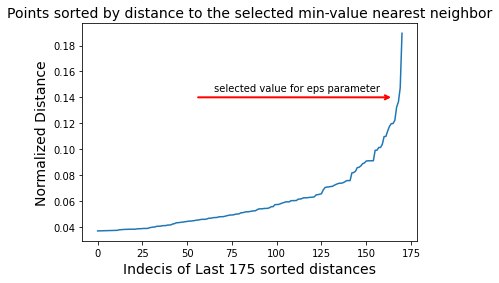

In [7]:
%matplotlib inline
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(scaled_X)
distances, indices = neighbors_fit.kneighbors(scaled_X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances[11360:len(distances)])
font = {'size':14}
plt.title('Points sorted by distance to the selected min-value nearest neighbor', fontdict=font)
plt.xlabel('Indecis of Last 175 sorted distances', fontdict=font)
plt.ylabel('Normalized Distance', fontdict=font)
plt.annotate(text='', xy = (165,0.14), xytext=(55,0.14), arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='red', lw=2))
plt.annotate(text='selected value for eps parameter', xy=(65, 0.145))
plt.show()

In [8]:
# build DBSCAN model
db = DBSCAN(eps=0.14, min_samples=4) 
db.fit(scaled_X)

DBSCAN(eps=0.14, min_samples=4)

In [9]:
# get number of unique clusters with value counts
print(np.unique(db.labels_, return_counts=True))

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([    8, 10923,   278,   166,    10,     7,     6,    29,    83,
           6,     5,     6,     4]))


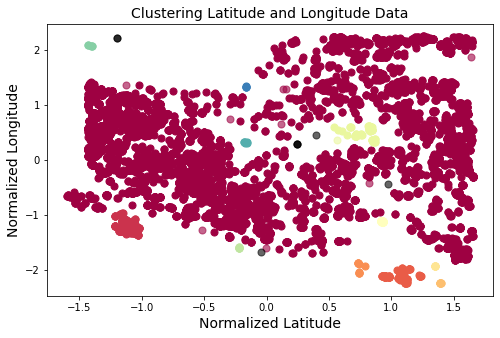

In [10]:
%matplotlib inline

#create temporary core_sample_mask and set True for core points and False for border and outlier points
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# set color for each label
unique_labels = set(db.labels_)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
# Plot the points with colors
plt.figure(figsize=(8, 5))
for label, color in zip(unique_labels, colors):
    if label == -1:
        color = 'k'

    class_member_mask = (db.labels_ == label)

    # Plot core points
    xy = scaled_X[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[color], marker=u'o')

    # Plot border points and outliers
    xy = scaled_X[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[color], marker=u'o', alpha=0.6)

font = {'size':14}    
plt.title('Clustering Latitude and Longitude Data' , fontdict=font)
plt.xlabel('Normalized Latitude', fontdict=font)
plt.ylabel('Normalized Longitude' , fontdict=font)
plt.show()

As the plot shows that based on the selected hyperparameters for the the algorithm, there are three clusters of fire data based based on the geographical coordinates of which 8 out of 11,500 coordinate data are determined to be noise and could be clusterd. We are not going to modify the dataset as the purpose of clustering here is to bring coordinately close fire occurences into same group.

In [11]:
# add location_group
df['location_group'] = db.labels_

## Plotting Clustered Fire Coordinates

Fire location coordinates have been adjusted to their nearest quarter degrees in order to be aligned with the weather data and grouping purpose. The process of this approximation is in the wildfire silver dataset generation python script file.

In [ ]:
colors_map = ['red', 'orange', 'darkgreen', 'purple', 'darkblue', 'lightred', 'white', 'lightblue', 'beige','darkpurple', 'lightgray', 'gray', 'pink','black']
ab_bc_map = folium.Map(location=[54.130, -120.35],zoom_start=5, tiles='Stamen Terrain', scrollWheelZoom=False)
cluster = MarkerCluster().add_to(ab_bc_map)

for lat, lon, color_index, label1, label2 in zip(df.lat_mean, df.lon_mean, df.location_group, df.UID_Fire, df.Date.dt.date):
    folium.features.CircleMarker(
        location=[lat, lon],
        radius=5,
        fill=True,
        color = colors_map[color_index],
        popup = folium.Popup(f'UID Fire: {label1} <br> Date: {label2}', max_width=len(f'name= {label2}')*20),
        ).add_to(cluster)

text_formatter = "function(num) {return L.Util.formatNum(num, 5);};"

mouse_position = MousePosition(
    position='topright',
    separator=' Lon: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=text_formatter,
    lng_formatter=text_formatter)

ab_bc_map.add_child(mouse_position)

## Feature Organizing

In [12]:
# identify features, and label data
to_drop = ['UID_Fire', 'REF_ID', 'Date', 'year', 'total_aob', 'month', 'location_group', 'lat_mean', 'lon_mean', 'lat_std', 'lon_std']
label = 'category_aob'
categorical = ['satelite']
continuous  = [col for col in df.columns if col not in to_drop + [label] + categorical]
print(categorical)
print(continuous)

['satelite']
['t21_mean', 't21_std', 't31_mean', 't31_std', 'frp_mean', 'frp_std', 'conf_mean', 'conf_std', 'temp_mean', 'temp_std', 'convective_energy_mean', 'convective_energy_std', 'dewpoint_temp_mean', 'dewpoint_temp_std', 'total_precipitation_mean', 'total_precipitation_std', 'total_cloud_cover_mean', 'total_cloud_cover_std', 'high_veg_cover_mean', 'low_veg_cover_mean', 'soil_water_mean', 'soil_water_std', 'wind_speed_mean', 'wind_speed_std']


In [13]:
# set indicators for categorical data
categorical_features_df = pd.get_dummies(df[categorical].astype('str'))
categorical_features_df.head()

,satelite_A,satelite_T
0,0,1
1,0,1
2,1,0
3,0,1
4,1,0


In [17]:
#normalizing all continuous values
X_all = df[continuous].to_numpy()
continuous_all_df = pd.DataFrame(X_all, columns=continuous)
features_all = pd.concat([continuous_all_df, categorical_features_df], axis = 1)
display(features_all.head())
display(features_all.shape)

,t21_mean,t21_std,t31_mean,t31_std,frp_mean,frp_std,conf_mean,conf_std,temp_mean,temp_std,...,total_cloud_cover_mean,total_cloud_cover_std,high_veg_cover_mean,low_veg_cover_mean,soil_water_mean,soil_water_std,wind_speed_mean,wind_speed_std,satelite_A,satelite_T
0,28.85,0.000000,2.85,0.000000,19.0,0.000000,50.0,0.000000,2.639483,2.444001,...,0.838529,0.187564,0.981841,0.000504,0.394290,0.005209,2.100145,0.372036,0,1
1,38.65,0.707107,23.05,0.565685,13.3,0.989949,70.5,0.707107,5.537388,7.054086,...,0.314304,0.386498,0.934903,0.065097,0.375507,0.004740,2.625103,0.524167,0,1
2,29.85,0.000000,14.35,0.000000,8.3,0.000000,35.0,0.000000,3.356584,3.368528,...,0.377443,0.275385,0.969969,0.028169,0.323027,0.001149,2.647607,0.683949,1,0
3,38.25,0.000000,14.55,0.000000,14.9,0.000000,71.0,0.000000,3.356584,3.368528,...,0.377443,0.275385,0.969969,0.028169,0.323027,0.001149,2.647607,0.683949,0,1
4,90.65,0.000000,9.25,0.000000,183.0,0.000000,0.0,0.000000,4.350320,4.777020,...,0.365491,0.313924,0.953703,0.046297,0.317802,0.001737,1.338031,0.759403,1,0


(11531, 26)

In [18]:
no_stds = [column for column in continuous if column.find('std') == -1]
X_no_stds = df[no_stds]
continuous_no_stds_df = pd.DataFrame(X_no_stds, columns=no_stds)
features_no_stds = pd.concat([continuous_no_stds_df, categorical_features_df], axis=1)
display(features_no_stds.head())
display(features_no_stds.shape)

,t21_mean,t31_mean,frp_mean,conf_mean,temp_mean,convective_energy_mean,dewpoint_temp_mean,total_precipitation_mean,total_cloud_cover_mean,high_veg_cover_mean,low_veg_cover_mean,soil_water_mean,wind_speed_mean,satelite_A,satelite_T
0,28.85,2.85,19.0,50.0,2.639483,0.723796,-0.887532,0.000000,0.838529,0.981841,0.000504,0.394290,2.100145,0,1
1,38.65,23.05,13.3,70.5,5.537388,0.000000,-7.583762,0.000000,0.314304,0.934903,0.065097,0.375507,2.625103,0,1
2,29.85,14.35,8.3,35.0,3.356584,6.887451,-5.593360,0.000005,0.377443,0.969969,0.028169,0.323027,2.647607,1,0
3,38.25,14.55,14.9,71.0,3.356584,6.887451,-5.593360,0.000005,0.377443,0.969969,0.028169,0.323027,2.647607,0,1
4,90.65,9.25,183.0,0.0,4.350320,3.652913,-6.729558,0.000035,0.365491,0.953703,0.046297,0.317802,1.338031,1,0


(11531, 15)

In [19]:
# Encoding label data
y = df[label]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
label_df = pd.DataFrame(y_encoded, columns=[label])
display(list(map(lambda x, y: x + ' --> ' + str(y), le.classes_, le.transform(le.classes_))))

['High --> 0',
 'Low --> 1',
 'Moderate --> 2',
 'Very High --> 3',
 'Very Low --> 4']

In [20]:
XY_all = pd.concat([features_all, label_df], axis=1)
XY_no_stds = pd.concat([features_no_stds, label_df], axis=1)
display(XY_all.shape, XY_no_stds.shape)

(11531, 27)

(11531, 16)

In [21]:
# save complete normalized and indicator features and label as csv
path = os.path.abspath(
        os.path.join(os.getcwd(), "../data/processed/features_label_all.csv"))
XY_all.to_csv(path, index = False)

In [22]:
# save without standard deviation dataset for features and labels as csv
path = os.path.abspath(
        os.path.join(os.getcwd(), "../data/processed/features_label_no_stds.csv"))
XY_no_stds.to_csv(path, index = False)

## <h3 align="center"> Copyright © 2022 - All rights reserved by the author.<h3/>